## Loop to get the Spatial Structure Parameters

In [1]:
using PyCall

using Distributions, Statistics, Distances
using DataFrames
using LightGraphs, SimpleWeightedGraphs
using Random , Printf, Glob

import PyPlot , CSV
import Distances, StatsBase

rootdir = "/home/stephane/Science/cluster/GAIA"

push!(LOAD_PATH,"$rootdir/master/src")
using GaiaClustering

## directory
wdir    = "$rootdir/products"
plotdir = "$rootdir/products/plotdens"
ocdir= "$wdir/oc2"

cd(wdir)

In [2]:
cd(ocdir)
files= glob("*-oc.csv")
cd(wdir)

df = DataFrame(voname= String[], C= Float64[], Cerr= Float64[], s= Float64[], serr= Float64[], m= Float64[],
merr= Float64[])

fitflag= true
noc= 0 ; nfail= 0

for f in files
    if fitflag
        fname= f[1:end-4] ; fvot= f[1:end-7]
        oc= CSV.read("$ocdir/$fname.csv" , delim= ";")
        ocfile= "$ocdir/$fname.csv" ; voname= "$fvot.vot"
        println("## ocfile: $voname")
        println("## fitting the radial profile....")
    
        ntest= 100 ; niter= 30000 ; nburnin= 5000
    
        ## estimating the binning
        nstar= length(oc.X)
        println("## Nstar: $nstar")
        nbin= min(trunc(Int, nstar/10),20)
        println("## NBIN: $nbin")
    
        verbose= false
        θfit, θfiterr, fitfound= spatialParameter(ocfile, ntest, nbin, niter, verbose, nburnin)
    
        println("## Fit:")
        println(θfit)
        println(θfiterr)
        println(" ")
    
        push!(df, [voname,θfit.C , θfiterr.C, θfit.s , θfiterr.s, θfit.m , θfiterr.m])
        
        noc += 1
        if !fitfound
            println("################################ Failing...########### ")
            println("###################################################### ")
            nfail += 1
        end
        
        println("## OCs analyzed: $noc")
        println("## Fit failed: $nfail \n\n")
    end
end

if fitflag 
    CSV.write("fitCauchy-p100-30k.csv", df, delim=";") 
else
    
    println("\n##\n## No fit...\n##")
end

## ocfile: ASCC 10-2.7deg.vot
## fitting the radial profile....
## Nstar: 119
## NBIN: 11
[1.7915301463051434, 3.981178102900319, 3.463624949523278, 2.132773983696599, 0.5971767154350477, 0.6514655077473251, 0.3215566929265639, 0.15924712411601283, 0.14051216833765826, 0.09429106033184965, 0.08531095934786395]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(4.1201324040427645, 4.0901051823660435, 2.9414236420130324)
GaiaClustering.modelCauchy(0.03775146349018574, 0.06236692807150529, 0.05730389750078035)
 
## OCs analyzed: 1
## Fit failed: 0 


## ocfile: ASCC 100-1.8deg.vot
## fitting the radial profile....
## Nstar: 149
## NBIN: 14
[0.0, 1.3361114218789711, 1.0203032676166692, 0.36439402414881034, 0.48585869886508054, 0.5631544009572524, 0.39242433369871876, 0.26722228437579426, 0.3429590815518214, 0.30685812559899833, 0.1908730602684244, 0.09505931064751581, 0.1603333706254767, 0.040488224905423316]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(0.9572900582372619, 6.

## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(2.224999749361035, 23.007441089309264, 6.45221152917268)
GaiaClustering.modelCauchy(0.03932367260503647, 0.7382207609608069, 0.3321816265386814)
 
## OCs analyzed: 15
## Fit failed: 0 


## ocfile: ASCC 127-3.4deg.vot
## fitting the radial profile....
## Nstar: 171
## NBIN: 17
[4.265361107213402, 2.258132350877683, 1.103975815984645, 0.6810240423281904, 0.3345381260559531, 0.41056951834139677, 0.23160331803873663, 0.13381525042238132, 0.1771084196766808, 0.1452599757874535, 0.0, 0.010908851936607166, 0.08028915025342882, 0.009292725723776457, 0.0, 0.016187328680126747, 0.007603139228544383]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(3.3821978254443334, 3.1550395194679375, 1.6213024293157159)
GaiaClustering.modelCauchy(0.06310714915198885, 0.05392742376547812, 0.014503010667039289)
 
## OCs analyzed: 16
## Fit failed: 0 


## ocfile: ASCC 16-3.3deg.vot
## fitting the radial profile....
## Nstar: 520
## NBIN: 20
[0.503056

## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(1.6017611848078084, 10.892273357050003, 2.3056886879664926)
GaiaClustering.modelCauchy(0.039370182747805994, 0.985354726391336, 0.2585046664123527)
 
## OCs analyzed: 28
## Fit failed: 0 


## ocfile: ASCC 33-2.6deg.vot
## fitting the radial profile....
## Nstar: 701
## NBIN: 20
[1.7355080071548448, 2.2778542593907334, 1.3667125556344406, 1.1466749332987365, 0.6267112248059159, 0.6409546617333239, 0.5840651947155726, 0.3687954515204044, 0.4785408107963724, 0.26831867215880817, 0.22726890569884858, 0.11790135918171527, 0.0997917104114036, 0.04017379646191768, 0.022441913885622982, 0.02099404847364731, 0.01643473491623907, 0.009297364324043798, 0.005863202726874487, 0.002781262831978911]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(1.590503131410761, 21.392414133978402, 4.446358486209549)
GaiaClustering.modelCauchy(0.03130653845998726, 1.042289837764552, 0.32053135693729523)
 
## OCs analyzed: 29
## Fit failed: 0 


## ocfi

## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(18.11851759346721, 8.076722844881019, 6.355290448463081)
GaiaClustering.modelCauchy(0.3673106387969353, 0.4074793969928094, 0.5423665150464724)
 
## OCs analyzed: 41
## Fit failed: 0 


## ocfile: ASCC 84-1.0deg.vot
## fitting the radial profile....
## Nstar: 149
## NBIN: 14
[1.3729335687183455, 1.8305780916244605, 1.9907536746416012, 1.9613336695976364, 0.5720556536326439, 0.4056394634849659, 0.23762311766279057, 0.16017558301714033, 0.10095099769987835, 0.03612983075574592, 0.06537778898658789, 0.029846381928659703, 0.027458671374366913, 0.012712347858503196]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(2.3621039119331404, 6.959581796043844, 3.682919203992285)
GaiaClustering.modelCauchy(0.02013625833683077, 0.09237587696901292, 0.06268925651462351)
 
## OCs analyzed: 42
## Fit failed: 0 


## ocfile: ASCC 89-3.8deg.vot
## fitting the radial profile....
## Nstar: 85
## NBIN: 8
[1.4809835057452858, 1.6661064439634465, 1.0

## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(19.705733767802503, 2.289530906212587, 2.0159939197130634)
GaiaClustering.modelCauchy(0.37669789621001476, 0.07054252451096253, 0.04618282391687185)
 
## OCs analyzed: 54
## Fit failed: 0 


## ocfile: Alessi 62-1.4deg.vot
## fitting the radial profile....
## Nstar: 92
## NBIN: 9
[4.0920406836033365, 1.4185741036491568, 0.4910448820324006, 0.2104478065853144, 0.2000553223094965, 0.05952059176150311, 0.012590894411087199, 0.0, 0.009628331020243144]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(4.509992472646941, 2.2884690055822663, 1.8161064214212332)
GaiaClustering.modelCauchy(0.056246337705713634, 0.03392217769781125, 0.0195179954837677)
 
## OCs analyzed: 55
## Fit failed: 0 


## ocfile: Alessi 9-4.5deg.vot
## fitting the radial profile....
## Nstar: 351
## NBIN: 20
[16.38271482727875, 9.89789020814758, 7.3722216722754395, 4.388227185878237, 4.436985265721326, 3.6302606719538164, 2.8354698739520914, 2.3891459123114847, 

## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(5.467740555712485, 3.6956002412471243, 3.3310883807953147)
GaiaClustering.modelCauchy(0.1483524541936178, 0.2509502749528245, 0.3610097935513727)
 
## OCs analyzed: 68
## Fit failed: 0 


## ocfile: C1331-622-1.0deg.vot
## fitting the radial profile....
## Nstar: 80
## NBIN: 8
[2.0863382469571388, 1.8545228861841234, 1.5299813811019018, 1.2915427243068, 1.0045332300163998, 1.0747803090385264, 0.48146267237472423, 0.2781784329276185]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(2.090391527524858, 5.247992266337494, 2.686122350878786)
GaiaClustering.modelCauchy(0.05528252355956743, 0.3548224362087542, 0.32607505759379535)
 
## OCs analyzed: 69
## Fit failed: 0 


## ocfile: CBJC 4-1.0deg.vot
## fitting the radial profile....
## Nstar: 269
## NBIN: 20
[24.54528610318401, 16.363524068789342, 11.603226157868809, 7.650478785408002, 4.462779291488003, 4.259925687329458, 3.947843219393228, 3.27270481375787, 1.8376150023774136, 2.

## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(2.034357936366238, 5.257224002873489, 2.8258079494877677)
GaiaClustering.modelCauchy(0.019337174029266206, 0.06885563187466646, 0.039563146526094266)
 
## OCs analyzed: 81
## Fit failed: 0 


## ocfile: Collinder 463-2.5deg.vot
## fitting the radial profile....
## Nstar: 189
## NBIN: 18
[1.6552184530253664, 1.517283581939919, 1.737979375676635, 1.1231839502672127, 1.0115223879599455, 0.6018976192819521, 0.6366224819328331, 0.4138046132563415, 0.21907303054747493, 0.32668785257079563, 0.1773448342527181, 0.12594053446932144, 0.14896966077228288, 0.06130438714908765, 0.05707649838018495, 0.013348535911494907, 0.025079067470081314, 0.011822988950181182]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(1.9103338893577082, 8.309150986462956, 3.193726963061661)
GaiaClustering.modelCauchy(0.043759677376246114, 0.4813143197688794, 0.22430998937095864)
 
## OCs analyzed: 82
## Fit failed: 0 


## ocfile: Collinder 65-7.5deg.vot
## fit

[30.375065699003, 24.09056934748514, 21.157804383443477, 23.79130761646047, 21.76297810618224, 22.852714005519502, 13.213556431396517, 8.239672994212311, 3.758375269044998, 2.094832117172622, 1.8953242964895127, 1.8671329740016853, 1.3825891973339286, 0.6206909976807757, 0.541766926854989, 0.5406018366897082, 0.28565892506899343, 0.14963086551233037, 0.05661708424790858, 0.05371364403006735]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(33.346532085799225, 7.636657634070877, 5.894122719498406)
GaiaClustering.modelCauchy(0.2361341288926396, 0.10304192462093002, 0.11487249929059143)
 
## OCs analyzed: 95
## Fit failed: 0 


## ocfile: ESO 128-16-1.0deg.vot
## fitting the radial profile....
## Nstar: 177
## NBIN: 17
[2.3080820762437044, 2.0516285122166265, 1.8464656609949626, 2.527899416838344, 2.308082076243705, 1.5387213841624678, 1.4203582007653581, 1.2822678201353912, 0.36205209039116915, 0.0809853360085511, 0.2198173405946383, 0.36795511360406835, 0.06154885536649874, 0.0569

## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(3.3420977697920193, 5.543722592752733, 3.1058648836554674)
GaiaClustering.modelCauchy(0.08220908864637118, 0.4693252237158153, 0.4041801059848961)
 
## OCs analyzed: 109
## Fit failed: 0 


## ocfile: FSR 0222-1.0deg.vot
## fitting the radial profile....
## Nstar: 162
## NBIN: 16
[1.3153799604596919, 2.1922999340994864, 1.0523039683677533, 1.5659285243567762, 0.8769199736397946, 0.9167799724416033, 0.6745538258767649, 0.43845998681989745, 0.051583527861164394, 0.18461473129258832, 0.25054856389708424, 0.07625391075128644, 0.0350767989455918, 0.016239258771107296, 0.015119309890341286, 0.014143870542577342]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(2.172821417749974, 6.889614250830916, 3.402225388241131)
GaiaClustering.modelCauchy(0.046379212468178076, 0.42413386302114686, 0.29047996261195813)
 
## OCs analyzed: 110
## Fit failed: 0 


## ocfile: FSR 0227-1.0deg.vot
## fitting the radial profile....
## Nstar: 158
## NBI

## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(3.825943795180475, 4.0387996941299935, 3.5796155578216404)
GaiaClustering.modelCauchy(0.12093583445739774, 0.36062733965091803, 0.46325467060149605)
 
## OCs analyzed: 124
## Fit failed: 0 


## ocfile: FSR 0581-1.0deg.vot
## fitting the radial profile....
## Nstar: 127
## NBIN: 12
[3.4774120335527403, 3.2842224761331433, 2.5501021579386767, 2.401070213643558, 1.2879303827973114, 0.684944794487661, 0.3120754389085793, 0.19318955741959662, 0.13636909935500943, 0.06100722865882002, 0.0, 0.050397275848590474]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(4.650557275219921, 4.292509889002369, 3.1066299965940103)
GaiaClustering.modelCauchy(0.11145604973440784, 0.3540601919985945, 0.3971769810150514)
 
## OCs analyzed: 125
## Fit failed: 0 


## ocfile: FSR 0596-1.0deg.vot
## fitting the radial profile....
## Nstar: 74
## NBIN: 7
[0.7871367936982558, 1.0495157249310079, 0.7346610074517057, 0.8246194981600774, 0.29153214581416903

## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(2.3298710038246058, 5.403408746990158, 3.4368246815119323)
GaiaClustering.modelCauchy(0.07710660218967208, 0.4069196785516014, 0.5287495507660143)
 
## OCs analyzed: 140
## Fit failed: 0 


## ocfile: FSR 1158-1.0deg.vot
## fitting the radial profile....
## Nstar: 49
## NBIN: 4
[0.8349240899035175, 0.19879144997702797, 0.06361326399264895, 0.02839877856814686]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(1.1345113828218554, 2.7285488272358087, 1.401662168602894)
GaiaClustering.modelCauchy(0.023863399968828587, 0.06921675361894526, 0.02438594932645775)
 
## OCs analyzed: 141
## Fit failed: 0 


## ocfile: FSR 1160-1.0deg.vot
## fitting the radial profile....
## Nstar: 80
## NBIN: 8
[0.8334842981558228, 0.8057014882172954, 0.20003623155739747, 0.1547899410860814, 0.09260936646175807, 0.03788564991617377, 0.0, 0.005556561987705488]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(0.9952687341625072, 5.919027469398705, 

## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(0.7060010247726598, 7.998342827011037, 1.9384771937823326)
GaiaClustering.modelCauchy(0.027237698594288404, 0.8614871079344162, 0.49550197718497774)
 
## OCs analyzed: 154
## Fit failed: 0 


## ocfile: FSR 1378-1.0deg.vot
## fitting the radial profile....
## Nstar: 73
## NBIN: 7
[2.261292312734031, 0.4845626384430067, 0.145368791532902, 0.10383485109493, 0.01794676438677803, 0.014683716316454744, 0.031061707592500435]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(3.5390772910821524, 1.6646928413338435, 1.3888968794041832)
GaiaClustering.modelCauchy(0.06319934329207896, 0.03466801990980563, 0.015070430134989338)
 
## OCs analyzed: 155
## Fit failed: 0 


## ocfile: FSR 1379-1.0deg.vot
## fitting the radial profile....
## Nstar: 47
## NBIN: 4
[1.0740219574585166, 0.11548623198478673, 0.027716695676348824, 0.00989881988441029]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(2.1663796023225985, 2.0654248524418857, 1.65

## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(5.545861257829516, 4.778633358948977, 2.6232236870919388)
GaiaClustering.modelCauchy(0.05943114442418897, 0.09188281855516954, 0.0501667166223434)
 
## OCs analyzed: 170
## Fit failed: 0 


## ocfile: FSR 1669-1.0deg.vot
## fitting the radial profile....
## Nstar: 253
## NBIN: 20
[7.429659252988859, 5.837589413062674, 3.2902776691807802, 2.729262582730601, 1.7100009391799764, 1.061379893284122, 0.8980906789327198, 0.6722072657466106, 0.2809535011634446, 0.3910346975257295, 0.12635474920049086, 0.2768817112915099, 0.0, 0.058965549626895694, 0.018299653332484903, 0.034238061073681283, 0.0, 0.0, 0.0, 0.013607434529283646]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(6.186296977528757, 4.131543245706032, 2.3038994509709414)
GaiaClustering.modelCauchy(0.06559934360570704, 0.07428494828470458, 0.038762391869514315)
 
## OCs analyzed: 171
## Fit failed: 0 


## ocfile: FSR 1688-1.0deg.vot
## fitting the radial profile....
## Nst

## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(3.2354964941459, 3.3455085731916276, 1.9599007861233435)
GaiaClustering.modelCauchy(0.03428916577758253, 0.041679252773849366, 0.018472529656159295)
 
## OCs analyzed: 184
## Fit failed: 0 


## ocfile: Hogg 10-1.0deg.vot
## fitting the radial profile....
## Nstar: 75
## NBIN: 7
[0.8551901593324734, 1.3540510856097496, 1.197266223065463, 0.2443400455235638, 0.19004225762943858, 0.07774455993931577, 0.06578385841019023]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(1.632830413174352, 4.568596830084012, 2.5068462531440336)
GaiaClustering.modelCauchy(0.026729664265493835, 0.350963457135106, 0.2873554680098625)
 
## OCs analyzed: 185
## Fit failed: 0 


## ocfile: Hogg 19-1.0deg.vot
## fitting the radial profile....
## Nstar: 356
## NBIN: 20
[20.239711300727542, 17.24123555247161, 12.593598142674914, 5.300876769238167, 4.872523090915893, 3.3732852167879206, 2.421845796668253, 1.4992378741279668, 0.9259998634319789, 0.828526193

## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(19.703882169895053, 4.075626490939828, 2.7398245874672766)
GaiaClustering.modelCauchy(0.13030921346244734, 0.04561964497587988, 0.031180607463833665)
 
## OCs analyzed: 197
## Fit failed: 0 


## ocfile: IC 446-1.0deg.vot
## fitting the radial profile....
## Nstar: 91
## NBIN: 9
[3.1616053398511195, 1.3549737170790512, 1.4453052982176553, 0.8387932534298886, 0.6022105409240228, 0.5337775249099296, 0.4516579056930171, 0.1204421081848045, 0.10627244839835702]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(2.350288220213199, 3.555655226099973, 1.843775581816236)
GaiaClustering.modelCauchy(0.06861121027055027, 0.4785343028954372, 0.35306258249969474)
 
## OCs analyzed: 198
## Fit failed: 0 


## ocfile: IC 4651-1.2deg.vot
## fitting the radial profile....
## Nstar: 592
## NBIN: 20
[27.481419789584145, 19.937500631659084, 11.63918955794152, 7.85183422559547, 6.376407859674753, 3.6739866028855803, 2.984407578959363, 1.99375006316

## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(9.89375369949801, 4.510834875393414, 3.501929816995328)
GaiaClustering.modelCauchy(0.2709814050519556, 0.3492454893783106, 0.4134417039580038)
 
## OCs analyzed: 211
## Fit failed: 0 


## ocfile: Loden 189-1.3deg.vot
## fitting the radial profile....
## Nstar: 104
## NBIN: 10
[4.228227821972164, 1.6443108196558414, 0.9396061826604803, 0.36913100033090324, 0.3654024043679648, 0.19219217372600725, 0.10841609799928628, 0.06264041217736539, 0.0, 0.012363239245532641]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(3.8965981012932596, 2.3869868272150963, 1.601759429090304)
GaiaClustering.modelCauchy(0.07207601834803788, 0.055107730756511514, 0.021757052875578133)
 
## OCs analyzed: 212
## Fit failed: 0 


## ocfile: Loden 2115-1.0deg.vot
## fitting the radial profile....
## Nstar: 485
## NBIN: 20
[6.545786287185071, 8.727715049580095, 5.79769642579249, 6.412198811936397, 4.259956155152187, 4.675561633703622, 3.1649955674301467, 

## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(0.09738852768576788, 8.958701232142683, 0.9768660689166471)
GaiaClustering.modelCauchy(0.09254428493970711, 0.9668305034909377, 0.04179918531058963)
 
## OCs analyzed: 226
## Fit failed: 0 


## ocfile: Melotte 20-5.5deg.vot
## fitting the radial profile....
## Nstar: 757
## NBIN: 20
[10.273019327510458, 9.588151372343093, 7.088383335982218, 6.604083853399577, 4.5087140381851425, 3.8290344766175393, 3.7536032158211263, 1.7806566834351458, 1.42009384821468, 1.2435760238565283, 0.4891913965481166, 0.5806489185114625, 0.47255888906548066, 0.3424339775836817, 0.21254522746573334, 0.19883263214536387, 0.06226072319703298, 0.014675741896443516, 0.027764917101379565, 0.03951161279811717]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(9.306942738678282, 9.19084592677542, 4.365179825031571)
GaiaClustering.modelCauchy(0.11032408708190934, 0.262430128486038, 0.17668261914971667)
 
## OCs analyzed: 227
## Fit failed: 0 


## ocfile: Me

## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(8.699904405417598, 5.458663797571584, 3.076042266181113)
GaiaClustering.modelCauchy(0.0638734299397293, 0.0592455556718633, 0.034926590191157306)
 
## OCs analyzed: 239
## Fit failed: 0 


## ocfile: NGC 1662-2.4deg.vot
## fitting the radial profile....
## Nstar: 179
## NBIN: 17
[6.976191891836167, 2.959596560172919, 1.585498157235492, 0.8606989996421246, 0.8455990171922629, 0.43240858833695217, 0.1219613967104225, 0.14797982800864598, 0.14922335597510522, 0.1168261800068258, 0.060399929799447284, 0.08272164298619956, 0.038051955773651856, 0.01174443079433697, 0.0, 0.010229020369261247, 0.03843631896328462]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(6.206702392355991, 2.134655479241892, 1.4616313203660642)
GaiaClustering.modelCauchy(0.10861306309927347, 0.03688352501027872, 0.011970518742469304)
 
## OCs analyzed: 240
## Fit failed: 0 


## ocfile: NGC 1664-1.6deg.vot
## fitting the radial profile....
## Nstar: 217
## N

## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(1.13615262662232, 3.699370540783521, 1.7946618674867056)
GaiaClustering.modelCauchy(0.015182120993427549, 0.07392203453754702, 0.0312925044762766)
 
## OCs analyzed: 252
## Fit failed: 0 


## ocfile: NGC 2168-4.9deg.vot
## fitting the radial profile....
## Nstar: 862
## NBIN: 20
[19.489551487546503, 17.05335755160319, 17.86542219691763, 10.440831154042769, 8.30110526321425, 6.05357281052581, 4.247722760106292, 3.3023962242787106, 2.961647529970302, 1.8805707575702761, 1.1214226054342236, 1.3769791811853513, 1.0069601601899034, 0.5413764302096256, 0.5040401246779266, 0.3143476046378465, 0.2706882151048127, 0.1160092350449196, 0.021947693116606444, 0.04164434078535572]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(17.000298957758677, 6.52353191676796, 3.6966298514903975)
GaiaClustering.modelCauchy(0.09300258475779166, 0.054595615015475996, 0.03564281734737898)
 
## OCs analyzed: 253
## Fit failed: 0 


## ocfile: NGC 2175-1

## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(4.118165676832673, 3.386533573924304, 2.4567255498270923)
GaiaClustering.modelCauchy(0.15063736540702002, 0.3153136714428179, 0.3223672772225132)
 
## OCs analyzed: 265
## Fit failed: 0 


## ocfile: NGC 2318-1.0deg.vot
## fitting the radial profile....
## Nstar: 122
## NBIN: 12
[1.6807878970727674, 1.0154760211481302, 0.4832265204084207, 0.22510552192938849, 0.15173779626351377, 0.06684951863357597, 0.04040355521809538, 0.06302954614022876, 0.00617936726864988, 0.005528907556160424, 0.01000468986352838, 0.004567358415958604]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(1.722756218378422, 5.107182766699045, 2.1829135507113113)
GaiaClustering.modelCauchy(0.021482299028656907, 0.07280325823102554, 0.025290765486728158)
 
## OCs analyzed: 266
## Fit failed: 0 


## ocfile: NGC 2323-2.3deg.vot
## fitting the radial profile....
## Nstar: 369
## NBIN: 20
[12.103563670024062, 11.154264558649626, 7.974112535545263, 5.797505287322

## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(23.09440594841427, 2.7947044074401672, 2.3289317470617785)
GaiaClustering.modelCauchy(0.17808310464059443, 0.026561479141931674, 0.017750272544282027)
 
## OCs analyzed: 278
## Fit failed: 0 


## ocfile: NGC 2428-1.0deg.vot
## fitting the radial profile....
## Nstar: 94
## NBIN: 9
[1.285586242630781, 0.46579211689521044, 0.1676851620822758, 0.05589505402742525, 0.07452673870323365, 0.02540684273973877, 0.012898858621713518, 0.0037263369351616836, 0.00986383306366328]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(1.5094728497354866, 3.4944261075607193, 1.6072845778765548)
GaiaClustering.modelCauchy(0.024132599354411408, 0.062426044019959985, 0.018280895659193153)
 
## OCs analyzed: 279
## Fit failed: 0 


## ocfile: NGC 2437-2.8deg.vot
## fitting the radial profile....
## Nstar: 435
## NBIN: 20
[23.12133291487933, 20.980468756094204, 17.726355234740808, 10.643153246531758, 7.136213862617074, 3.152909033847179, 2.6678461055

## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(4.196368607517837, 6.8299976697736975, 2.795477477413949)
GaiaClustering.modelCauchy(0.035510910872744474, 0.10331359623971424, 0.04305483405214195)
 
## OCs analyzed: 290
## Fit failed: 0 


## ocfile: NGC 2567-1.0deg.vot
## fitting the radial profile....
## Nstar: 80
## NBIN: 8
[1.5497409403402744, 0.7068993762955638, 0.24469593794846434, 0.06991312512813269, 0.05437687509965874, 0.029660113690722953, 0.0, 0.021750750039863508]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(1.982618741141629, 2.7218246560329407, 1.475978240061056)
GaiaClustering.modelCauchy(0.024812391043770084, 0.0485520304420273, 0.019403646984480334)
 
## OCs analyzed: 291
## Fit failed: 0 


## ocfile: NGC 2571-1.0deg.vot
## fitting the radial profile....
## Nstar: 142
## NBIN: 14
[1.398238485697702, 1.5730182964099149, 1.2234586749854892, 0.4993708877491792, 0.40781955832849615, 0.12711258960888208, 0.05377840329606543, 0.058259936904070934, 0.030843

## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(3.2723389533273566, 5.5799427792837095, 3.7074967111653354)
GaiaClustering.modelCauchy(0.09412407082300402, 0.26212566565240275, 0.25670087670630914)
 
## OCs analyzed: 303
## Fit failed: 0 


## ocfile: NGC 3680-1.0deg.vot
## fitting the radial profile....
## Nstar: 71
## NBIN: 7
[2.032227899437233, 0.6021415998332542, 0.0602141599833254, 0.0752676999791568, 0.0250892333263856, 0.027370072719693345, 0.011579646150639495]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(3.173097092524883, 1.7011710078473383, 1.4216476292865219)
GaiaClustering.modelCauchy(0.07076114190153963, 0.044628837660927, 0.02140858835839223)
 
## OCs analyzed: 304
## Fit failed: 0 


## ocfile: NGC 381-1.0deg.vot
## fitting the radial profile....
## Nstar: 124
## NBIN: 12
[10.53580929391582, 5.07279706744095, 3.0436782404645695, 1.5887331474952429, 0.5853227385508788, 0.47890042245071895, 0.2701489562542519, 0.0, 0.1032922479795669, 0.0616129198474609, 

## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(5.02731351707828, 3.7870609675437423, 1.9124938877554676)
GaiaClustering.modelCauchy(0.04879673991362151, 0.048473695236143734, 0.018274050504875447)
 
## OCs analyzed: 316
## Fit failed: 0 


## ocfile: NGC 5925-1.0deg.vot
## fitting the radial profile....
## Nstar: 251
## NBIN: 20
[7.156426929779064, 4.373372012642761, 2.3854756432596873, 1.931099330257843, 1.6786680452568172, 0.72287140704839, 0.6728264634835017, 0.2915581341761842, 0.2806441933246689, 0.2092522494087447, 0.1135940782504615, 0.08643027692969868, 0.031806341910129154, 0.07362579145863238, 0.027419260267352755, 0.02565027573397514, 0.0, 0.0, 0.0, 0.010194340355810617]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(4.93610709356057, 4.4474106446793735, 2.2134728104762726)
GaiaClustering.modelCauchy(0.04397739097596444, 0.05265141322743936, 0.023306249193829096)
 
## OCs analyzed: 317
## Fit failed: 0 


## ocfile: NGC 6025-1.7deg.vot
## fitting the radial p

## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(14.548730732606275, 1.7158752697706345, 1.5825573349403526)
GaiaClustering.modelCauchy(0.18355001387865205, 0.019321099501665096, 0.010902635318736446)
 
## OCs analyzed: 328
## Fit failed: 0 


## ocfile: NGC 6281-1.6deg.vot
## fitting the radial profile....
## Nstar: 437
## NBIN: 20
[50.30154533584298, 34.33280078478172, 24.43217916312373, 17.451556545088383, 8.782809503083694, 10.234513553180172, 4.237859130858565, 4.311561028786543, 2.677113057089681, 2.143173610800328, 2.0531242994221603, 2.291167696456618, 1.5329994769018798, 1.3307287125884393, 0.49558172744672896, 0.386340593977289, 0.5080964175337662, 0.34218738323702746, 0.38842892151230135, 0.30709124136656263]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(94.76193621210554, 0.6044346256163703, 1.1019090313986715)
GaiaClustering.modelCauchy(8.988643361389919, 0.14468985677034663, 0.0660291336987194)
 
## OCs analyzed: 329
## Fit failed: 0 


## ocfile: NGC 6383-

## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(0.4661573178279711, 5.796757891534761, 1.033564961587423)
GaiaClustering.modelCauchy(0.01480020445649032, 1.221131129082961, 0.38496381568537563)
 
## OCs analyzed: 340
## Fit failed: 0 


## ocfile: NGC 6910-1.0deg.vot
## fitting the radial profile....
## Nstar: 153
## NBIN: 15
[1.9324679362385948, 1.6103899468654959, 1.6425977458028052, 1.6564010882045102, 1.127272962805846, 0.9223142422956933, 0.3716284492766529, 0.4509091851223389, 0.31260510733271357, 0.2034176774987993, 0.13803342401704258, 0.06301525879038897, 0.019324679362385938, 0.017893221631838853, 0.033318412693768895]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(2.3716939434514437, 7.329513268350851, 3.6511223953653977)
GaiaClustering.modelCauchy(0.06758049569085275, 0.5382701504394629, 0.4348051356720283)
 
## OCs analyzed: 341
## Fit failed: 0 


## ocfile: NGC 6913-1.0deg.vot
## fitting the radial profile....
## Nstar: 96
## NBIN: 9
[0.46938567720193436, 

## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(32.70111097033357, 0.9039027783623717, 1.4226254856984124)
GaiaClustering.modelCauchy(3.0232534997028644, 0.16054440111465915, 0.08959850625161966)
 
## OCs analyzed: 353
## Fit failed: 0 


## ocfile: NGC 7160-1.1deg.vot
## fitting the radial profile....
## Nstar: 91
## NBIN: 9
[1.8582233735871998, 1.0839636345925332, 0.5574670120761598, 0.15485194779893335, 0.17205771977659257, 0.14077449799903022, 0.05955844146112825, 0.06194077911957331, 0.0182178762116392]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(2.1366016853381415, 2.4162933089650256, 1.2976334901192572)
GaiaClustering.modelCauchy(0.032930858157342036, 0.04402935630579336, 0.01568880168097869)
 
## OCs analyzed: 354
## Fit failed: 0 


## ocfile: NGC 7209-1.2deg.vot
## fitting the radial profile....
## Nstar: 160
## NBIN: 16
[2.2493769953518936, 1.1535266642830226, 0.8997507981407581, 0.6179607130087618, 0.23070533285660455, 0.28313836305128764, 0.22626869184013

## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(31.077726139148737, 1.530364136606791, 1.5580830024017034)
GaiaClustering.modelCauchy(0.47119166418966635, 0.026605807185350192, 0.016370637416412603)
 
## OCs analyzed: 367
## Fit failed: 0 


## ocfile: Patchick 75-1.0deg.vot
## fitting the radial profile....
## Nstar: 63
## NBIN: 6
[1.7810650775743813, 1.3456936141673101, 0.16623274057360896, 0.06785009819330975, 0.013193074648699125, 0.0215886676069622]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(2.5237227359845935, 3.7341745861107842, 3.065345644358392)
GaiaClustering.modelCauchy(0.03892776763875813, 0.23492966189498155, 0.29209836947120815)
 
## OCs analyzed: 368
## Fit failed: 0 


## ocfile: Per OB2-4.0deg.vot
## fitting the radial profile....
## Nstar: 240
## NBIN: 20
[21.50253804073914, 50.172588761724654, 29.24345173540522, 14.130239283914293, 12.423688645760395, 12.510567587339128, 6.2853572734468255, 3.4404060865182626, 2.5297103577340168, 2.2634250569199104

## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(4.079801421245484, 9.005587844823449, 4.031783544221942)
GaiaClustering.modelCauchy(0.10034174575542552, 0.5100656421054947, 0.35270217505992146)
 
## OCs analyzed: 381
## Fit failed: 0 


## ocfile: Platais 8-6.0deg.vot
## fitting the radial profile....
## Nstar: 396
## NBIN: 20
[1.823109947130399, 1.4179744033236437, 2.0661912734144527, 2.083554225291884, 1.5530195845925614, 1.3258981433675643, 1.308899449221825, 1.093865968278239, 0.6434505695754348, 0.5757189306727571, 0.8681475938716202, 0.6605470822936229, 0.6806277135953491, 0.5401807250756739, 0.5448374554642567, 0.5880999829452901, 0.38672029181553924, 0.2083554225291883, 0.09854648362867043, 0.07791068150129885]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(1.9940334185966433, 10.599923351379138, 2.5670204092981166)
GaiaClustering.modelCauchy(0.04321545026364216, 1.0932209247975635, 0.4354273438139765)
 
## OCs analyzed: 382
## Fit failed: 0 


## ocfile: Platais

## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(0.36961059949235603, 18.55541266071461, 4.18176482370729)
GaiaClustering.modelCauchy(0.012324802943671663, 1.2520831597815631, 0.5186192088864856)
 
## OCs analyzed: 395
## Fit failed: 0 


## ocfile: Ruprecht 24-1.0deg.vot
## fitting the radial profile....
## Nstar: 88
## NBIN: 8
[0.966890735276391, 0.6983099754773936, 0.5801344411658346, 0.34531811974156823, 0.30439152777219725, 0.19044817513019816, 0.06198017533823021, 0.010743230391959896]
## OC fitting done.
## Fit:
GaiaClustering.modelCauchy(1.0993362078041107, 7.920637482947582, 3.4650712763974307)
GaiaClustering.modelCauchy(0.038166686470396755, 0.5978430416158869, 0.4772770884118324)
 
## OCs analyzed: 396
## Fit failed: 0 


## ocfile: Ruprecht 26-1.1deg.vot
## fitting the radial profile....
## Nstar: 109
## NBIN: 10
[2.0578502469822677, 2.5478145915018553, 2.293033132351671, 0.41996943815964644, 0.29397860671175247, 0.21380262306309294, 0.1582961728447899, 0.039197147561

"fitCauchy-p100-30k.csv"

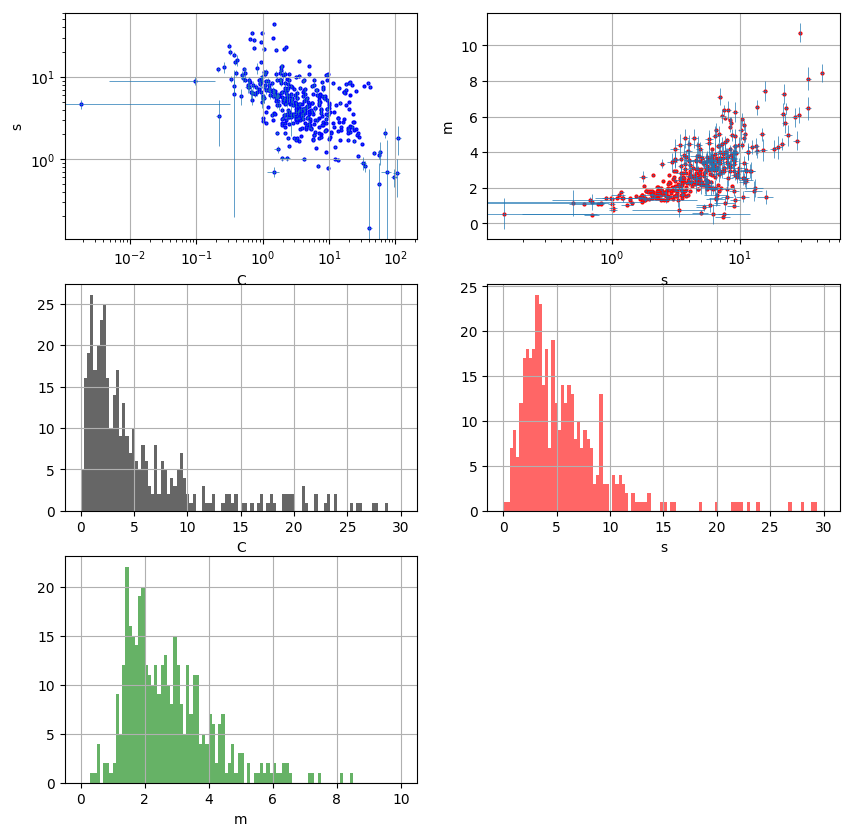

In [6]:
csvfile= "fitCauchy-p100-30k.csv"
df= CSV.read(csvfile , delim= ";")


fig= PyPlot.figure(figsize=(10,10))

ax= PyPlot.subplot(321)
PyPlot.grid("on")
ax.set_xscale("log")
ax.set_yscale("log")
PyPlot.xlabel("C")
PyPlot.ylabel("s")
PyPlot.scatter(df.C, df.s , s=4, facecolor="blue" )
PyPlot.errorbar(df.C, df.s, xerr=df.Cerr, yerr=df.serr, linewidth=0.5,ls="none")


ax= PyPlot.subplot(322)
PyPlot.grid("on")
ax.set_xscale("log")
#ax.set_yscale("log")
PyPlot.xlabel("s")
PyPlot.ylabel("m")
PyPlot.scatter(df.s, df.m , s=4, facecolor="red" )
PyPlot.errorbar(df.s, df.m, xerr=df.serr, yerr=df.merr, linewidth=0.5,ls="none")

ax = PyPlot.subplot(323)
PyPlot.grid("on")
nbins = 100
h = PyPlot.hist(df.C,nbins,range = [0,30], color = "k", alpha=0.6 , label = "C")
PyPlot.xlabel("C")

ax = PyPlot.subplot(324)
PyPlot.grid("on")
nbins = 100
h = PyPlot.hist(df.s,nbins,range = [0,30], color = "r", alpha=0.6 , label = "s")
PyPlot.xlabel("s")

ax = PyPlot.subplot(325)
PyPlot.grid("on")
nbins = 100
h = PyPlot.hist(df.m,nbins,range = [0,10], color = "g", alpha=0.6 , label = "s")
PyPlot.xlabel("m")

PyPlot.show()

--------------
## Checking all the fit with data.

Figs saved with data density with Cauchy Fit.

In [7]:
function _plotFitDensityFig(filelist, θlist, ifig, nrow, ncol, ocdir)
    
    fig= PyPlot.figure(figsize=(15,10))
    
    for i in 1:length(filelist)
        ocname= filelist[i][1:end-4]
        θ= θlist[i]
        ocfile= "$ocdir/$ocname-oc.csv"
        _plotDensity(ocfile, θ,nrow, ncol, i, ocname)
    end
    
    figname= "densityOC-$ifig.png"
    PyPlot.savefig(figname)
    PyPlot.close(fig)
end


function _plotDensity(ocfile, θ, irow, icol, nplot, title)
    oc= CSV.read(ocfile, delim= ";")
    # binned density
    nstar= length(oc.X)
    nbin= min(trunc(Int, nstar/10),20)
    r2d,ρ2d,err2d= density2D(oc.Y, oc.Z, nbin)
    ρ2dfit= model_rad(r2d, θ, fdens1)
    
    ax= PyPlot.subplot(irow, icol, nplot)
    ax.set_xlabel("r [pc]")
    ax.set_ylabel("ρ")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlim(r2d[1]*0.9, r2d[end]*1.1)
    ax.set_ylim(minimum(ρ2d[ρ2d .> 0])*0.3,maximum(ρ2d)*1.5)
    PyPlot.grid("on")
    PyPlot.scatter(r2d, ρ2d , s=4, facecolor="blue" )
    PyPlot.errorbar(r2d, ρ2d, yerr=2 .* err2d, linewidth=0.5)
    PyPlot.plot(r2d, ρ2dfit, "k-", linewidth=1)
    
    ## TEXT
    ax.text(0.02, 0.01, title, verticalalignment= "bottom" , horizontalalignment="left",
        transform=ax.transAxes, color="green", fontsize=15)
    
    val=θ.C ; txt= @sprintf("C= %3.3f",val)
    ax.text(0.02, 0.2, txt, verticalalignment= "bottom" , horizontalalignment="left",
        transform=ax.transAxes, color="red", fontsize=12)
    val=θ.s ; txt= @sprintf("s= %3.3f [pc]",val)
    ax.text(0.02, 0.3, txt, verticalalignment= "bottom" , horizontalalignment="left",
        transform=ax.transAxes, color="red", fontsize=12) 
    val=θ.m ; txt= @sprintf("m= %3.3f",val)
    ax.text(0.02, 0.4, txt, verticalalignment= "bottom" , horizontalalignment="left",
        transform=ax.transAxes, color="red", fontsize=12)
    
    val= nstar ; txt= @sprintf("Nstar= %d",val)
    ax.text(0.02, 0.52, txt, verticalalignment= "bottom" , horizontalalignment="left",
        transform=ax.transAxes, color="blue", fontsize=12)
    
end

_plotDensity (generic function with 1 method)

In [8]:
cd(plotdir)

rowperfig= 4
colperfig= 3
plotperfig= rowperfig*colperfig

ifig= 1
plotaccum=0
filevot= [] ; θlist= [] ; θerrlist= []
for item in 1:length(df.voname)
    push!(filevot, df.voname[item])
    θ= GaiaClustering.modelCauchy(df.C[item], df.s[item], df.m[item])
    push!(θlist, θ)
    θerr= GaiaClustering.modelCauchy(df.Cerr[item], df.serr[item], df.merr[item])
    push!(θerrlist, θerr)
    plotaccum += 1
    
    if plotaccum == plotperfig
        _plotFitDensityFig(filevot, θlist, ifig,rowperfig, colperfig , ocdir)
        println("## Fig $ifig done.")
        filevot= [] ; θlist= [] ; θerrlist= []
        plotaccum= 0 ; ifig += 1

    end
end

cd(wdir)

## Fig 1 done.
## Fig 2 done.
## Fig 3 done.
## Fig 4 done.
## Fig 5 done.
## Fig 6 done.
## Fig 7 done.
## Fig 8 done.
## Fig 9 done.
## Fig 10 done.
## Fig 11 done.
## Fig 12 done.
## Fig 13 done.
## Fig 14 done.
## Fig 15 done.
## Fig 16 done.
## Fig 17 done.
## Fig 18 done.
## Fig 19 done.
## Fig 20 done.
## Fig 21 done.
## Fig 22 done.
## Fig 23 done.
## Fig 24 done.
## Fig 25 done.
## Fig 26 done.
## Fig 27 done.
## Fig 28 done.
## Fig 29 done.
## Fig 30 done.
## Fig 31 done.
## Fig 32 done.
## Fig 33 done.
